In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Cargar el dataset
file_path = 'dataset/itesal.csv'
data = pd.read_csv(file_path, delimiter=';')

In [3]:
data.shape 

(79299, 30)

In [4]:

# Convertir columnas de fechas a objetos datetime
date_columns = ['FECHA_FACTURA', 'MAX_FECHA_COBRO', 'FECHA_CONTABILIZACION']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73198/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73198/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [5]:
# Extraer características de las fechas
for col in date_columns:
    data[col + '_YEAR'] = data[col].dt.year
    data[col + '_MONTH'] = data[col].dt.month
    data[col + '_DAY'] = data[col].dt.day
    data[col + '_WEEKDAY'] = data[col].dt.weekday

In [6]:

# Eliminar las columnas originales de fecha si ya no son necesarias
data.drop(columns=date_columns, inplace=True)


In [7]:
columns_to_drop = ['EMPRESA', 'NUMERO_FACTURA', 'NUMERO_ASIENTO_BORRADOR', 'DIVISA', 'TIPO_FACTURA', 'DIARIO', 'IMPORTE_COBRADO_FRA', 'CUENTA_CONTABLE','NUM_EFECTOS_COBRADOS', 'NUM_EFECTOS_PARCIAL', 'NUM_EFECTOS_IMPAGADO', 'NUM_EFECTOS_FUERA_PLAZO', 'NUM_EFECTOS_PDTE_EN_PLAZO']
data.drop(columns=columns_to_drop, inplace=True)

In [8]:
# Convertir todas las entradas en las columnas categóricas a cadenas
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    data[column] = data[column].astype(str)


In [9]:

# Convertir columnas categóricas a variables numéricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [10]:

# Visualización inicial del dataset
print("Primeras filas del dataset:")
data.head()

Primeras filas del dataset:


,EJERCICIO,NUMERO_SERIE,ORGANIZACION_COMERCIAL,CLIENTE,MES_FACTURA,FORMA_COBRO,CENTRO_CONTABLE,LIQUIDO_FACTURA,ALBARAN_FACTURA,ENVIO_ELECTRONICO,...,FECHA_FACTURA_DAY,FECHA_FACTURA_WEEKDAY,MAX_FECHA_COBRO_YEAR,MAX_FECHA_COBRO_MONTH,MAX_FECHA_COBRO_DAY,MAX_FECHA_COBRO_WEEKDAY,FECHA_CONTABILIZACION_YEAR,FECHA_CONTABILIZACION_MONTH,FECHA_CONTABILIZACION_DAY,FECHA_CONTABILIZACION_WEEKDAY
0,2018,27,703,700233,3,30,7,60876,0,0,...,15,3,NaN,NaN,NaN,NaN,2018,3,15,3
1,2018,27,703,700642,3,30,7,15044,0,0,...,15,3,2018.0,4.0,4.0,2.0,2018,3,15,3
2,2018,27,703,700506,3,57,7,37449,0,0,...,15,3,2018.0,10.0,5.0,4.0,2018,3,15,3
3,2018,27,703,700416,3,38,7,14067,0,0,...,15,3,NaN,NaN,NaN,NaN,2018,3,15,3
4,2018,27,703,700507,3,44,7,15401,0,0,...,15,3,NaN,NaN,NaN,NaN,2018,3,15,3


In [11]:
# Análisis Exploratorio de Datos (EDA)
# Resumen estadístico
print("\nResumen estadístico del dataset:")
data.describe()


Resumen estadístico del dataset:


,EJERCICIO,NUMERO_SERIE,ORGANIZACION_COMERCIAL,CLIENTE,MES_FACTURA,FORMA_COBRO,CENTRO_CONTABLE,LIQUIDO_FACTURA,ALBARAN_FACTURA,ENVIO_ELECTRONICO,...,FECHA_FACTURA_DAY,FECHA_FACTURA_WEEKDAY,MAX_FECHA_COBRO_YEAR,MAX_FECHA_COBRO_MONTH,MAX_FECHA_COBRO_DAY,MAX_FECHA_COBRO_WEEKDAY,FECHA_CONTABILIZACION_YEAR,FECHA_CONTABILIZACION_MONTH,FECHA_CONTABILIZACION_DAY,FECHA_CONTABILIZACION_WEEKDAY
count,79299.000000,79299.000000,79299.000000,7.929900e+04,79299.000000,79299.000000,79299.000000,79299.000000,79299.000000,79299.000000,...,79299.000000,79299.000000,27313.000000,27313.000000,27313.000000,27313.000000,79299.000000,79299.000000,79299.000000,79299.000000
mean,2020.421632,16.854336,577.187190,1.198347e+06,6.261403,49.729341,5.769266,30481.387155,0.126307,0.726718,...,23.002270,2.776794,2020.461795,5.765606,6.505254,2.980156,2020.421645,6.261403,23.002270,2.776794
std,1.678915,11.356171,275.914293,2.434304e+06,3.371704,25.426216,2.660442,17807.789032,0.332197,0.445647,...,8.655704,1.919839,1.676018,3.381322,3.239316,1.991389,1.678901,3.371704,8.655704,1.919839
min,2018.000000,0.000000,101.000000,1.000010e+05,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2018.000000,1.000000,1.000000,0.000000,2018.000000,1.000000,1.000000,0.000000
25%,2019.000000,10.000000,601.000000,6.000010e+05,3.000000,34.000000,6.000000,15094.000000,0.000000,0.000000,...,15.000000,1.000000,2019.000000,3.000000,4.000000,1.000000,2019.000000,3.000000,15.000000,1.000000
50%,2020.000000,15.000000,602.000000,6.009900e+05,6.000000,54.000000,6.000000,30420.000000,0.000000,1.000000,...,28.000000,3.000000,2020.000000,5.000000,6.000000,3.000000,2020.000000,6.000000,28.000000,3.000000
75%,2022.000000,18.000000,703.000000,7.007840e+05,9.000000,61.000000,7.000000,45928.500000,0.000000,1.000000,...,31.000000,4.000000,2022.000000,9.000000,9.000000,5.000000,2022.000000,9.000000,31.000000,4.000000
max,2023.000000,53.000000,1003.000000,1.051302e+07,12.000000,108.000000,10.000000,61394.000000,1.000000,1.000000,...,31.000000,6.000000,2023.000000,12.000000,12.000000,6.000000,2023.000000,12.000000,31.000000,6.000000


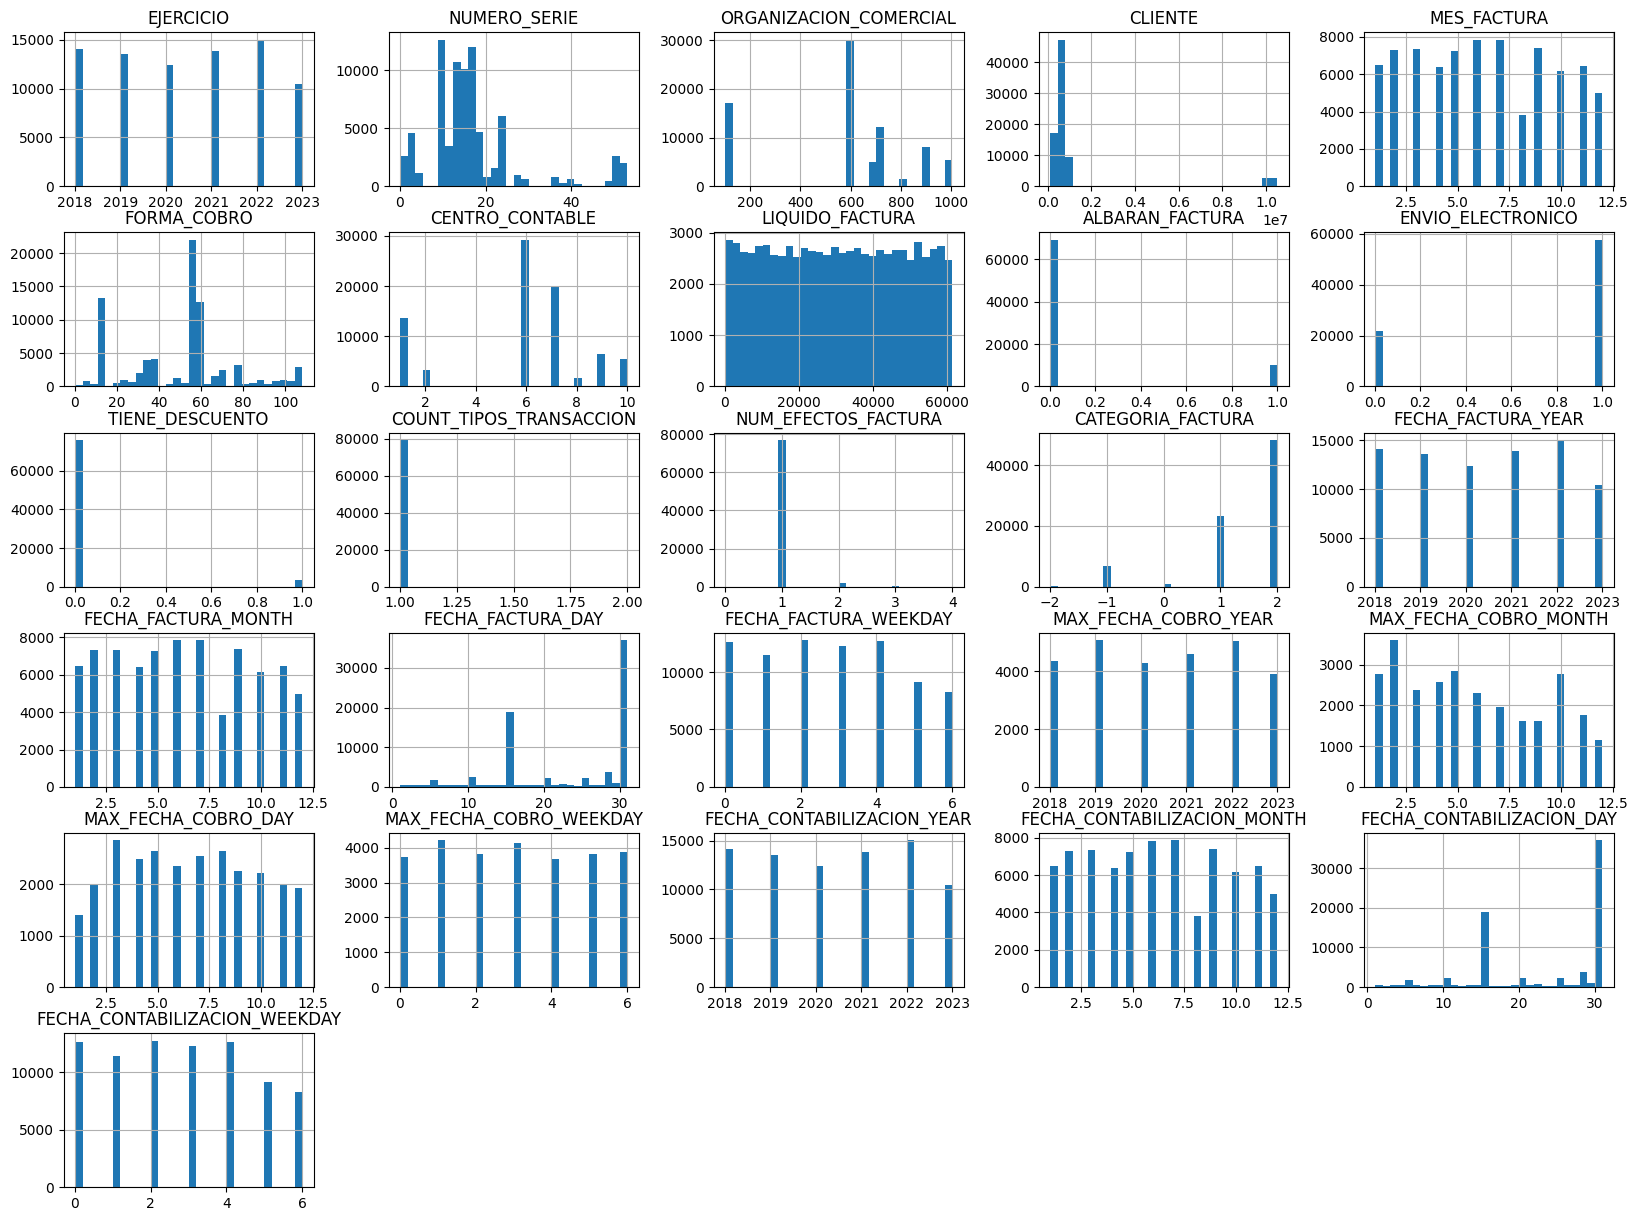

In [12]:

# Distribuciones de las características
data.hist(bins=30, figsize=(20, 15))
plt.show()


In [13]:

# Análisis de valores nulos
print("\nValores nulos en el dataset:")
data.isnull().sum()



Valores nulos en el dataset:


EJERCICIO                            0
NUMERO_SERIE                         0
ORGANIZACION_COMERCIAL               0
CLIENTE                              0
MES_FACTURA                          0
FORMA_COBRO                          0
CENTRO_CONTABLE                      0
LIQUIDO_FACTURA                      0
ALBARAN_FACTURA                      0
ENVIO_ELECTRONICO                    0
TIENE_DESCUENTO                      0
COUNT_TIPOS_TRANSACCION             48
NUM_EFECTOS_FACTURA                  0
CATEGORIA_FACTURA                    0
FECHA_FACTURA_YEAR                   0
FECHA_FACTURA_MONTH                  0
FECHA_FACTURA_DAY                    0
FECHA_FACTURA_WEEKDAY                0
MAX_FECHA_COBRO_YEAR             51986
MAX_FECHA_COBRO_MONTH            51986
MAX_FECHA_COBRO_DAY              51986
MAX_FECHA_COBRO_WEEKDAY          51986
FECHA_CONTABILIZACION_YEAR           0
FECHA_CONTABILIZACION_MONTH          0
FECHA_CONTABILIZACION_DAY            0
FECHA_CONTABILIZACION_WEE

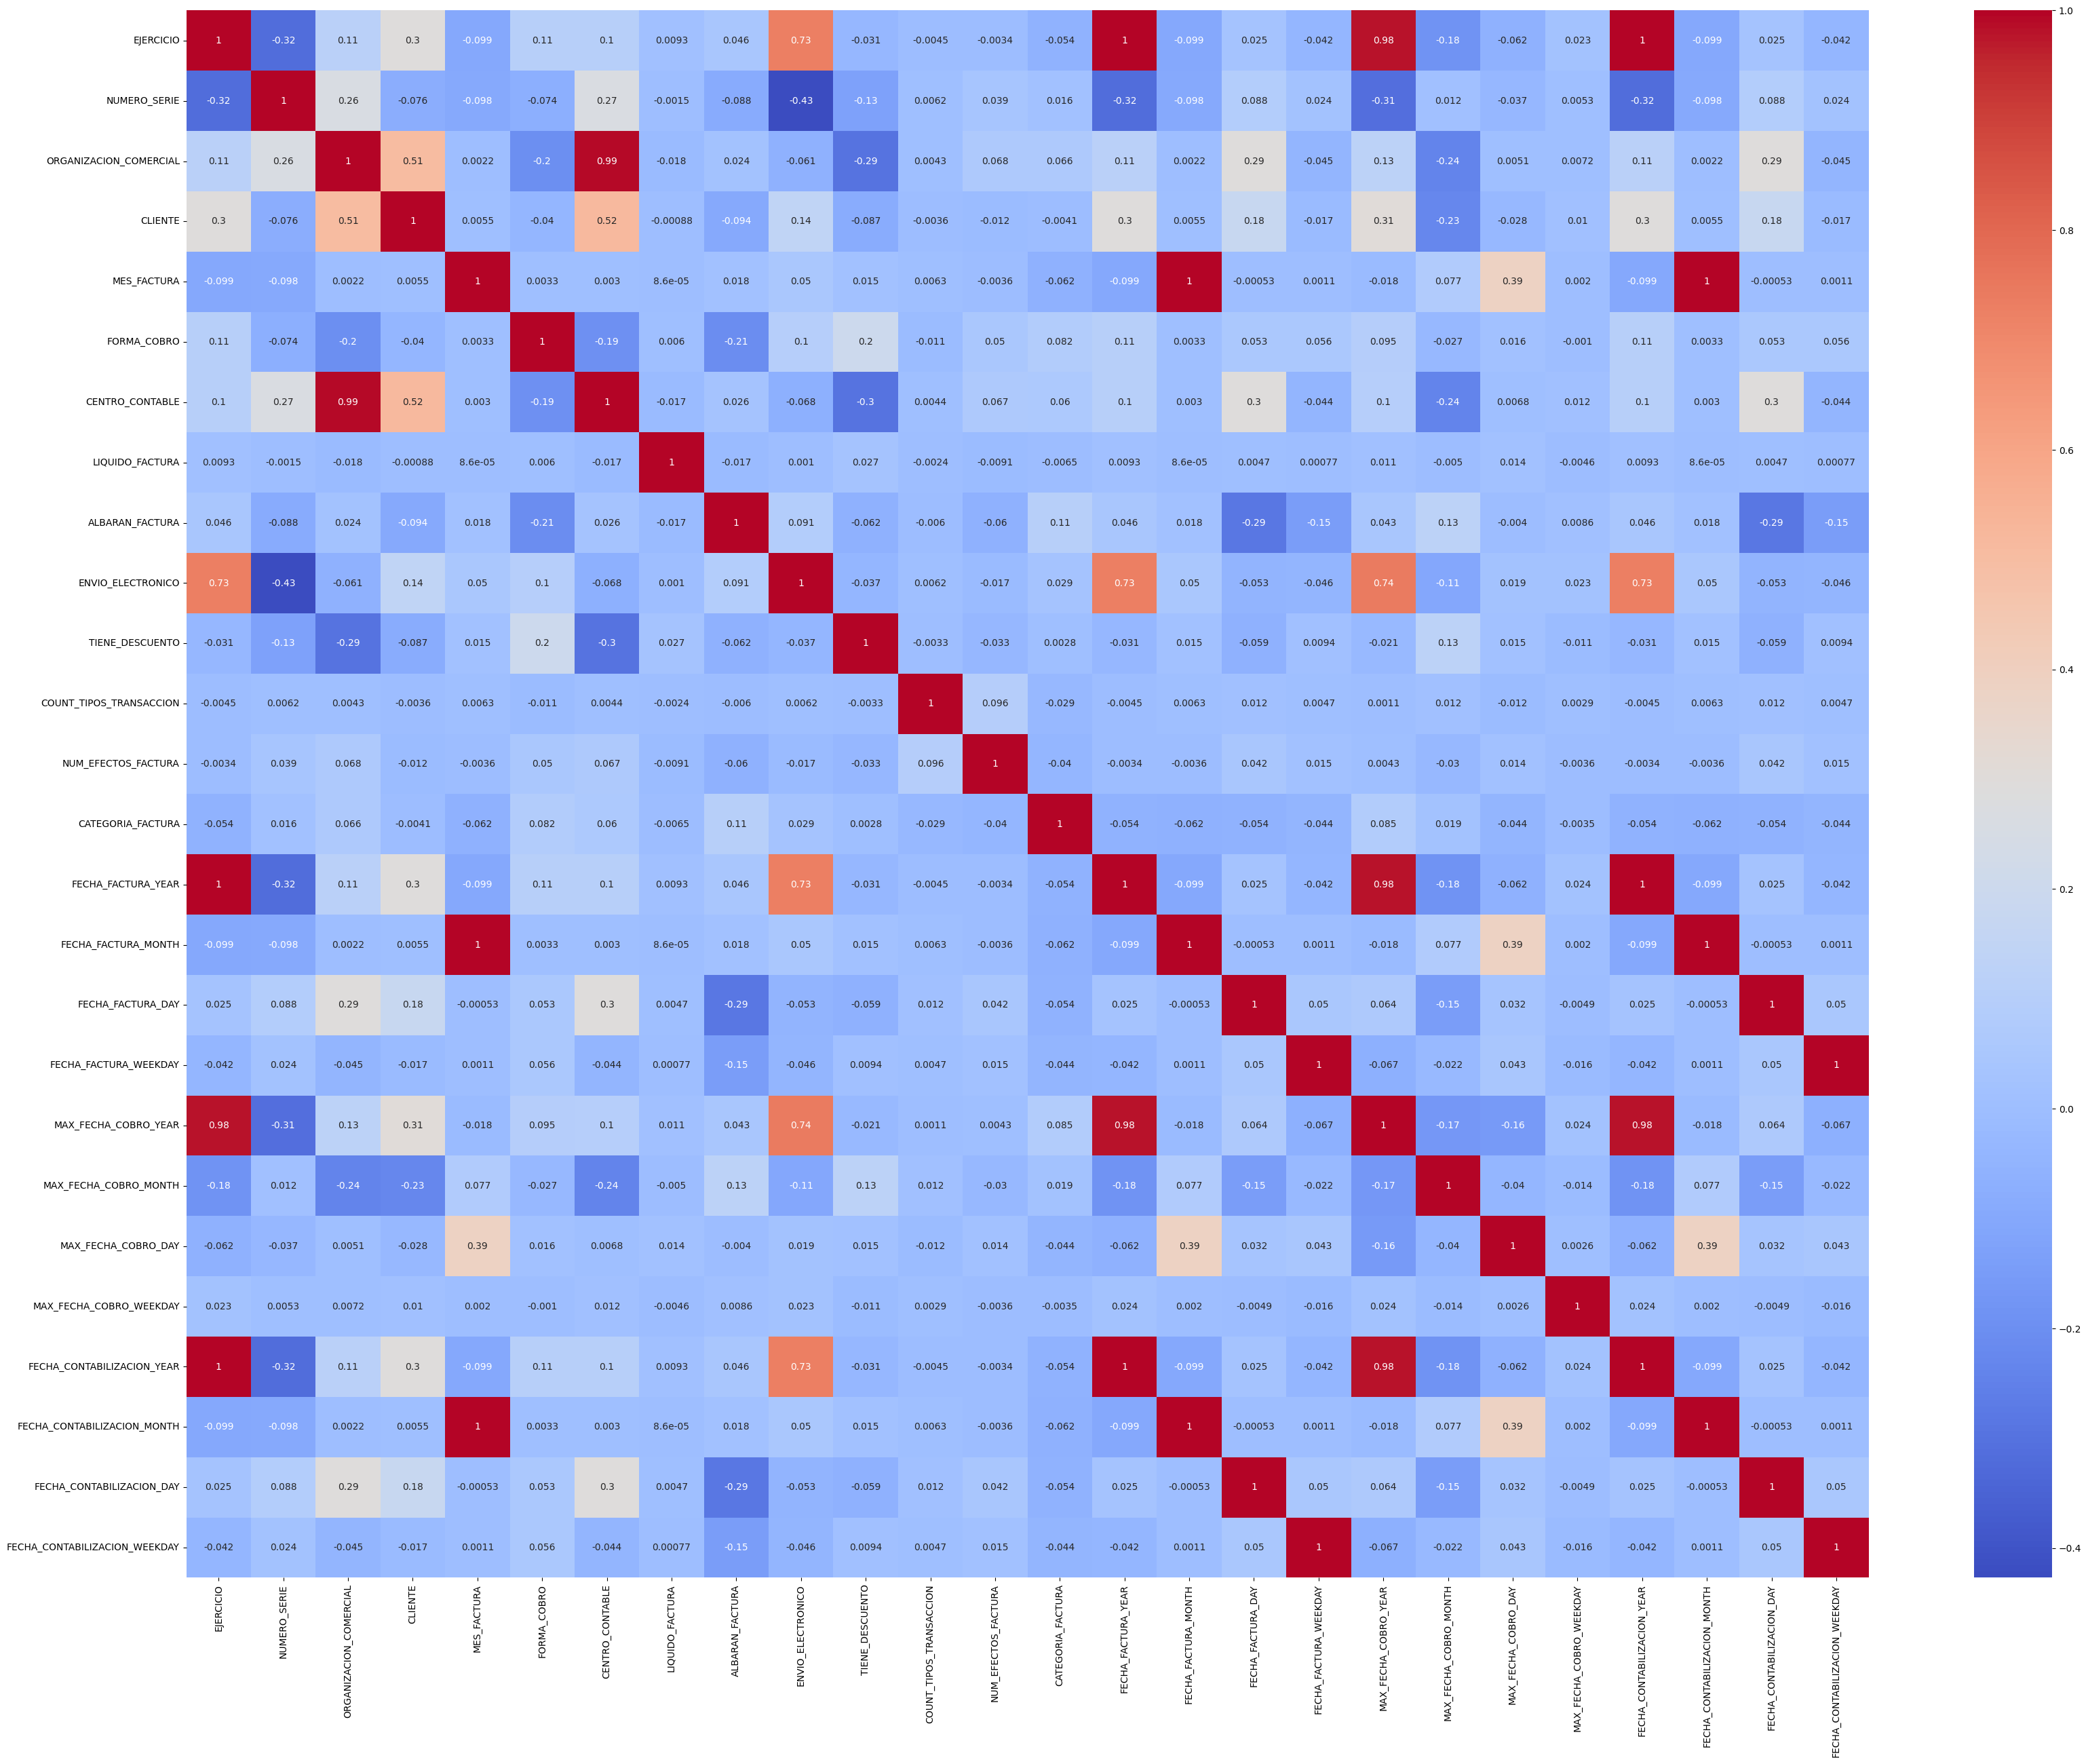

In [14]:
# Correlaciones entre las características
plt.figure(figsize=(40, 30))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [15]:

# Manejo de valores nulos
data.fillna(data.mean(), inplace=True)


In [16]:

# Separación de características y variable objetivo
X = data.drop('CATEGORIA_FACTURA', axis=1)
#y = data['CATEGORIA_FACTURA']
# Re-codificar las clases de la variable objetivo
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(data['CATEGORIA_FACTURA'])


In [17]:

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:

# Estandarización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:

# Entrenamiento y Validación de Modelos de Clasificación

# Árboles de Decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("\nÁrboles de Decisión:")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))



Árboles de Decisión:
              precision    recall  f1-score   support

           0       0.12      0.11      0.11        44
           1       0.67      0.71      0.69      1307
           2       0.24      0.29      0.26       143
           3       0.69      0.70      0.69      4686
           4       0.85      0.84      0.85      9680

    accuracy                           0.78     15860
   macro avg       0.51      0.53      0.52     15860
weighted avg       0.78      0.78      0.78     15860

[[   5    1    0   13   25]
 [   3  928   21  161  194]
 [   0   15   41   51   36]
 [  14  200   71 3258 1143]
 [  21  236   35 1251 8137]]


In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini', max_features='sqrt')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.05      0.09        44
           1       0.77      0.73      0.75      1307
           2       0.59      0.31      0.41       143
           3       0.76      0.70      0.73      4686
           4       0.85      0.90      0.87      9680

    accuracy                           0.82     15860
   macro avg       0.73      0.54      0.57     15860
weighted avg       0.81      0.82      0.81     15860

[[   2    1    0   12   29]
 [   0  957    6  122  222]
 [   0   11   45   47   40]
 [   1  122   20 3273 1270]
 [   0  146    5  845 8684]]


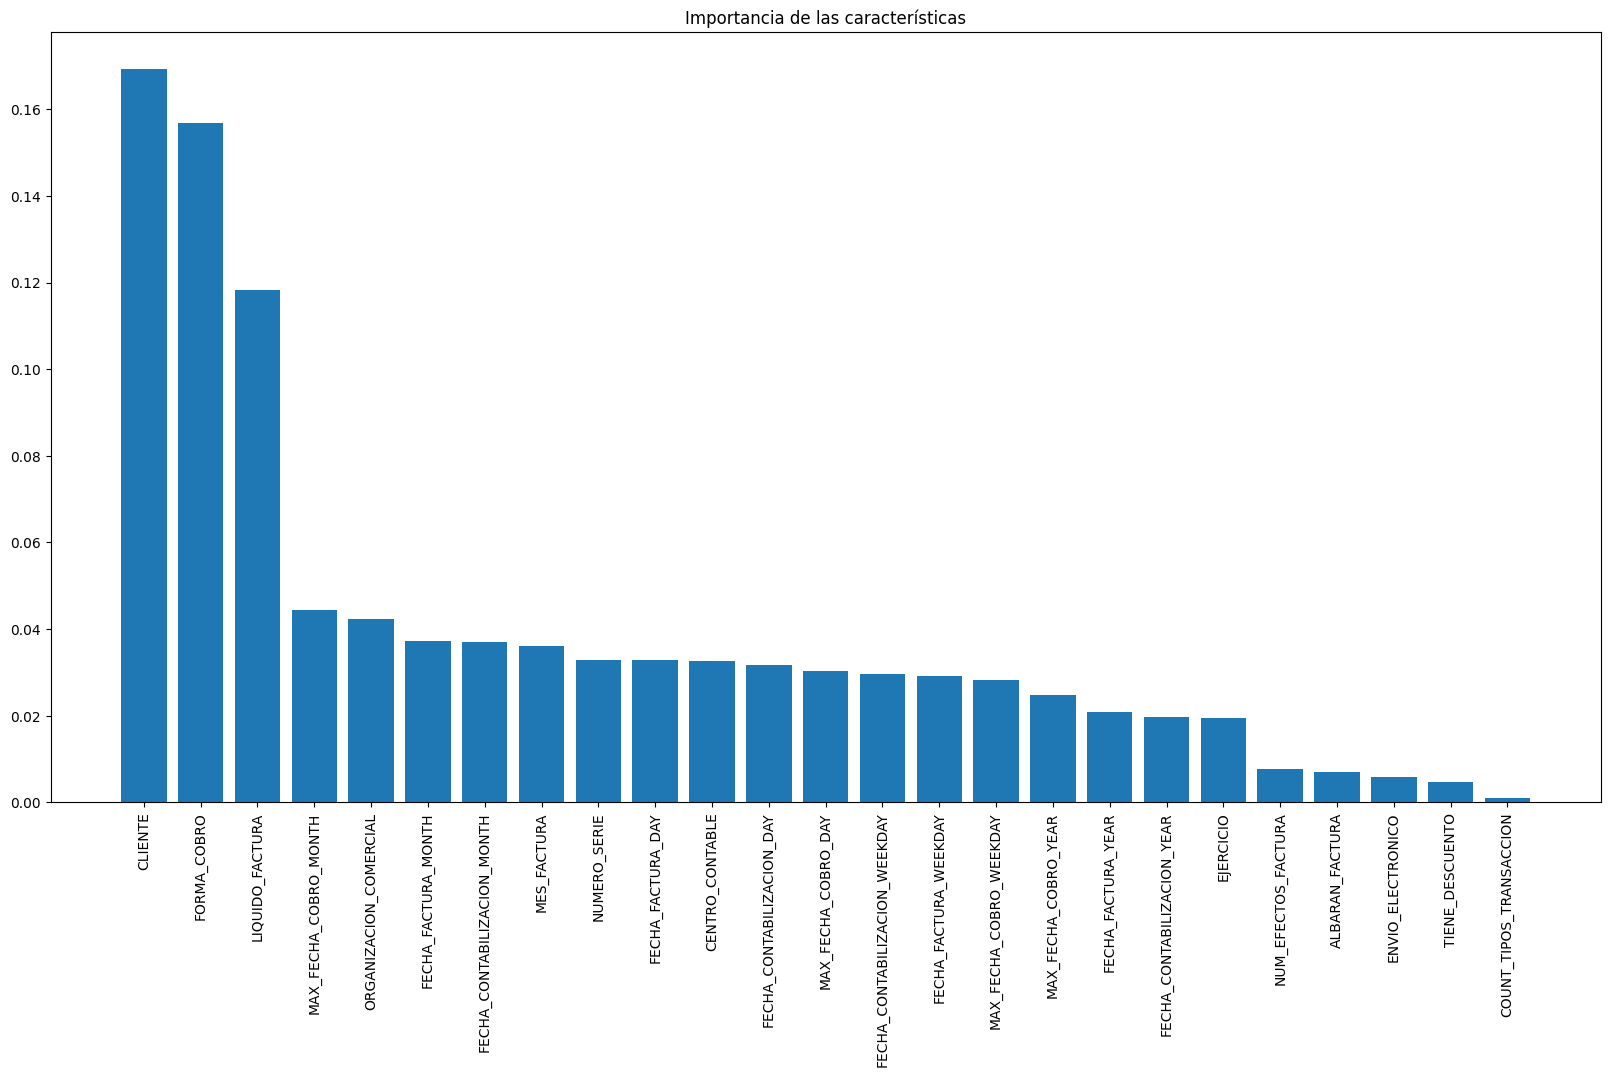

In [21]:
#revisamos la importancia de cada feature
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(20, 10))
plt.title("Importancia de las características")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

In [22]:
# evaluamos el modelo random forest
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))

# evaluamos el sobreajuste
y_pred_train_rf = rf.predict(X_train)
print("Accuracy Train: ", accuracy_score(y_train, y_pred_train_rf))


Accuracy:  0.8172131147540984
Accuracy Train:  0.9999369473037091


In [23]:
# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("\nSupport Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


Support Vector Machine:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.65      0.54      0.59      1307
           2       0.59      0.14      0.23       143
           3       0.76      0.38      0.50      4686
           4       0.72      0.92      0.81      9680

    accuracy                           0.72     15860
   macro avg       0.54      0.40      0.43     15860
weighted avg       0.72      0.72      0.69     15860

[[   0    0    0   11   33]
 [   0  709    4   15  579]
 [   0    4   20   41   78]
 [   0  127    7 1764 2788]
 [   0  250    3  491 8936]]


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [24]:
# evaluamos el modelo svm
print("Accuracy: ", accuracy_score(y_test, y_pred_svm))

Accuracy:  0.7206179066834805


In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
# SVM con búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print("\nMejores hiperparámetros para SVM:")
print(grid.best_params_)

y_pred_svm = label_encoder_y.inverse_transform(grid.predict(X_test))
print("\nSupport Vector Machine:")
print(classification_report(label_encoder_y.inverse_transform(y_test), y_pred_svm))
print(confusion_matrix(label_encoder_y.inverse_transform(y_test), y_pred_svm))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 5.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 5.7min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 6.8min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 7.5min


In [25]:
# XGBoost
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)
print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       0.71      0.11      0.20        44
           1       0.77      0.77      0.77      1307
           2       0.61      0.36      0.45       143
           3       0.80      0.65      0.72      4686
           4       0.84      0.92      0.87      9680

    accuracy                           0.82     15860
   macro avg       0.75      0.56      0.60     15860
weighted avg       0.82      0.82      0.81     15860

[[   5    0    0   11   28]
 [   0 1004    8   77  218]
 [   0   16   51   55   21]
 [   1  126   17 3058 1484]
 [   1  153    8  637 8881]]
